<a href="https://colab.research.google.com/github/emrullahozkilinc/machine-learning/blob/master/Depression_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import math


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
conditions = []
for x in range(1,24):
  conditions.append(pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/condition/condition_%s.csv'%(x)))

controls = []
for x in range(1,33):
  controls.append(pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/control/control_%s.csv'%(x)))

scores = pd.read_csv('https://raw.githubusercontent.com/emrullahozkilinc/machine-learning/master/dataset/the_depression_dataset/scores.csv')

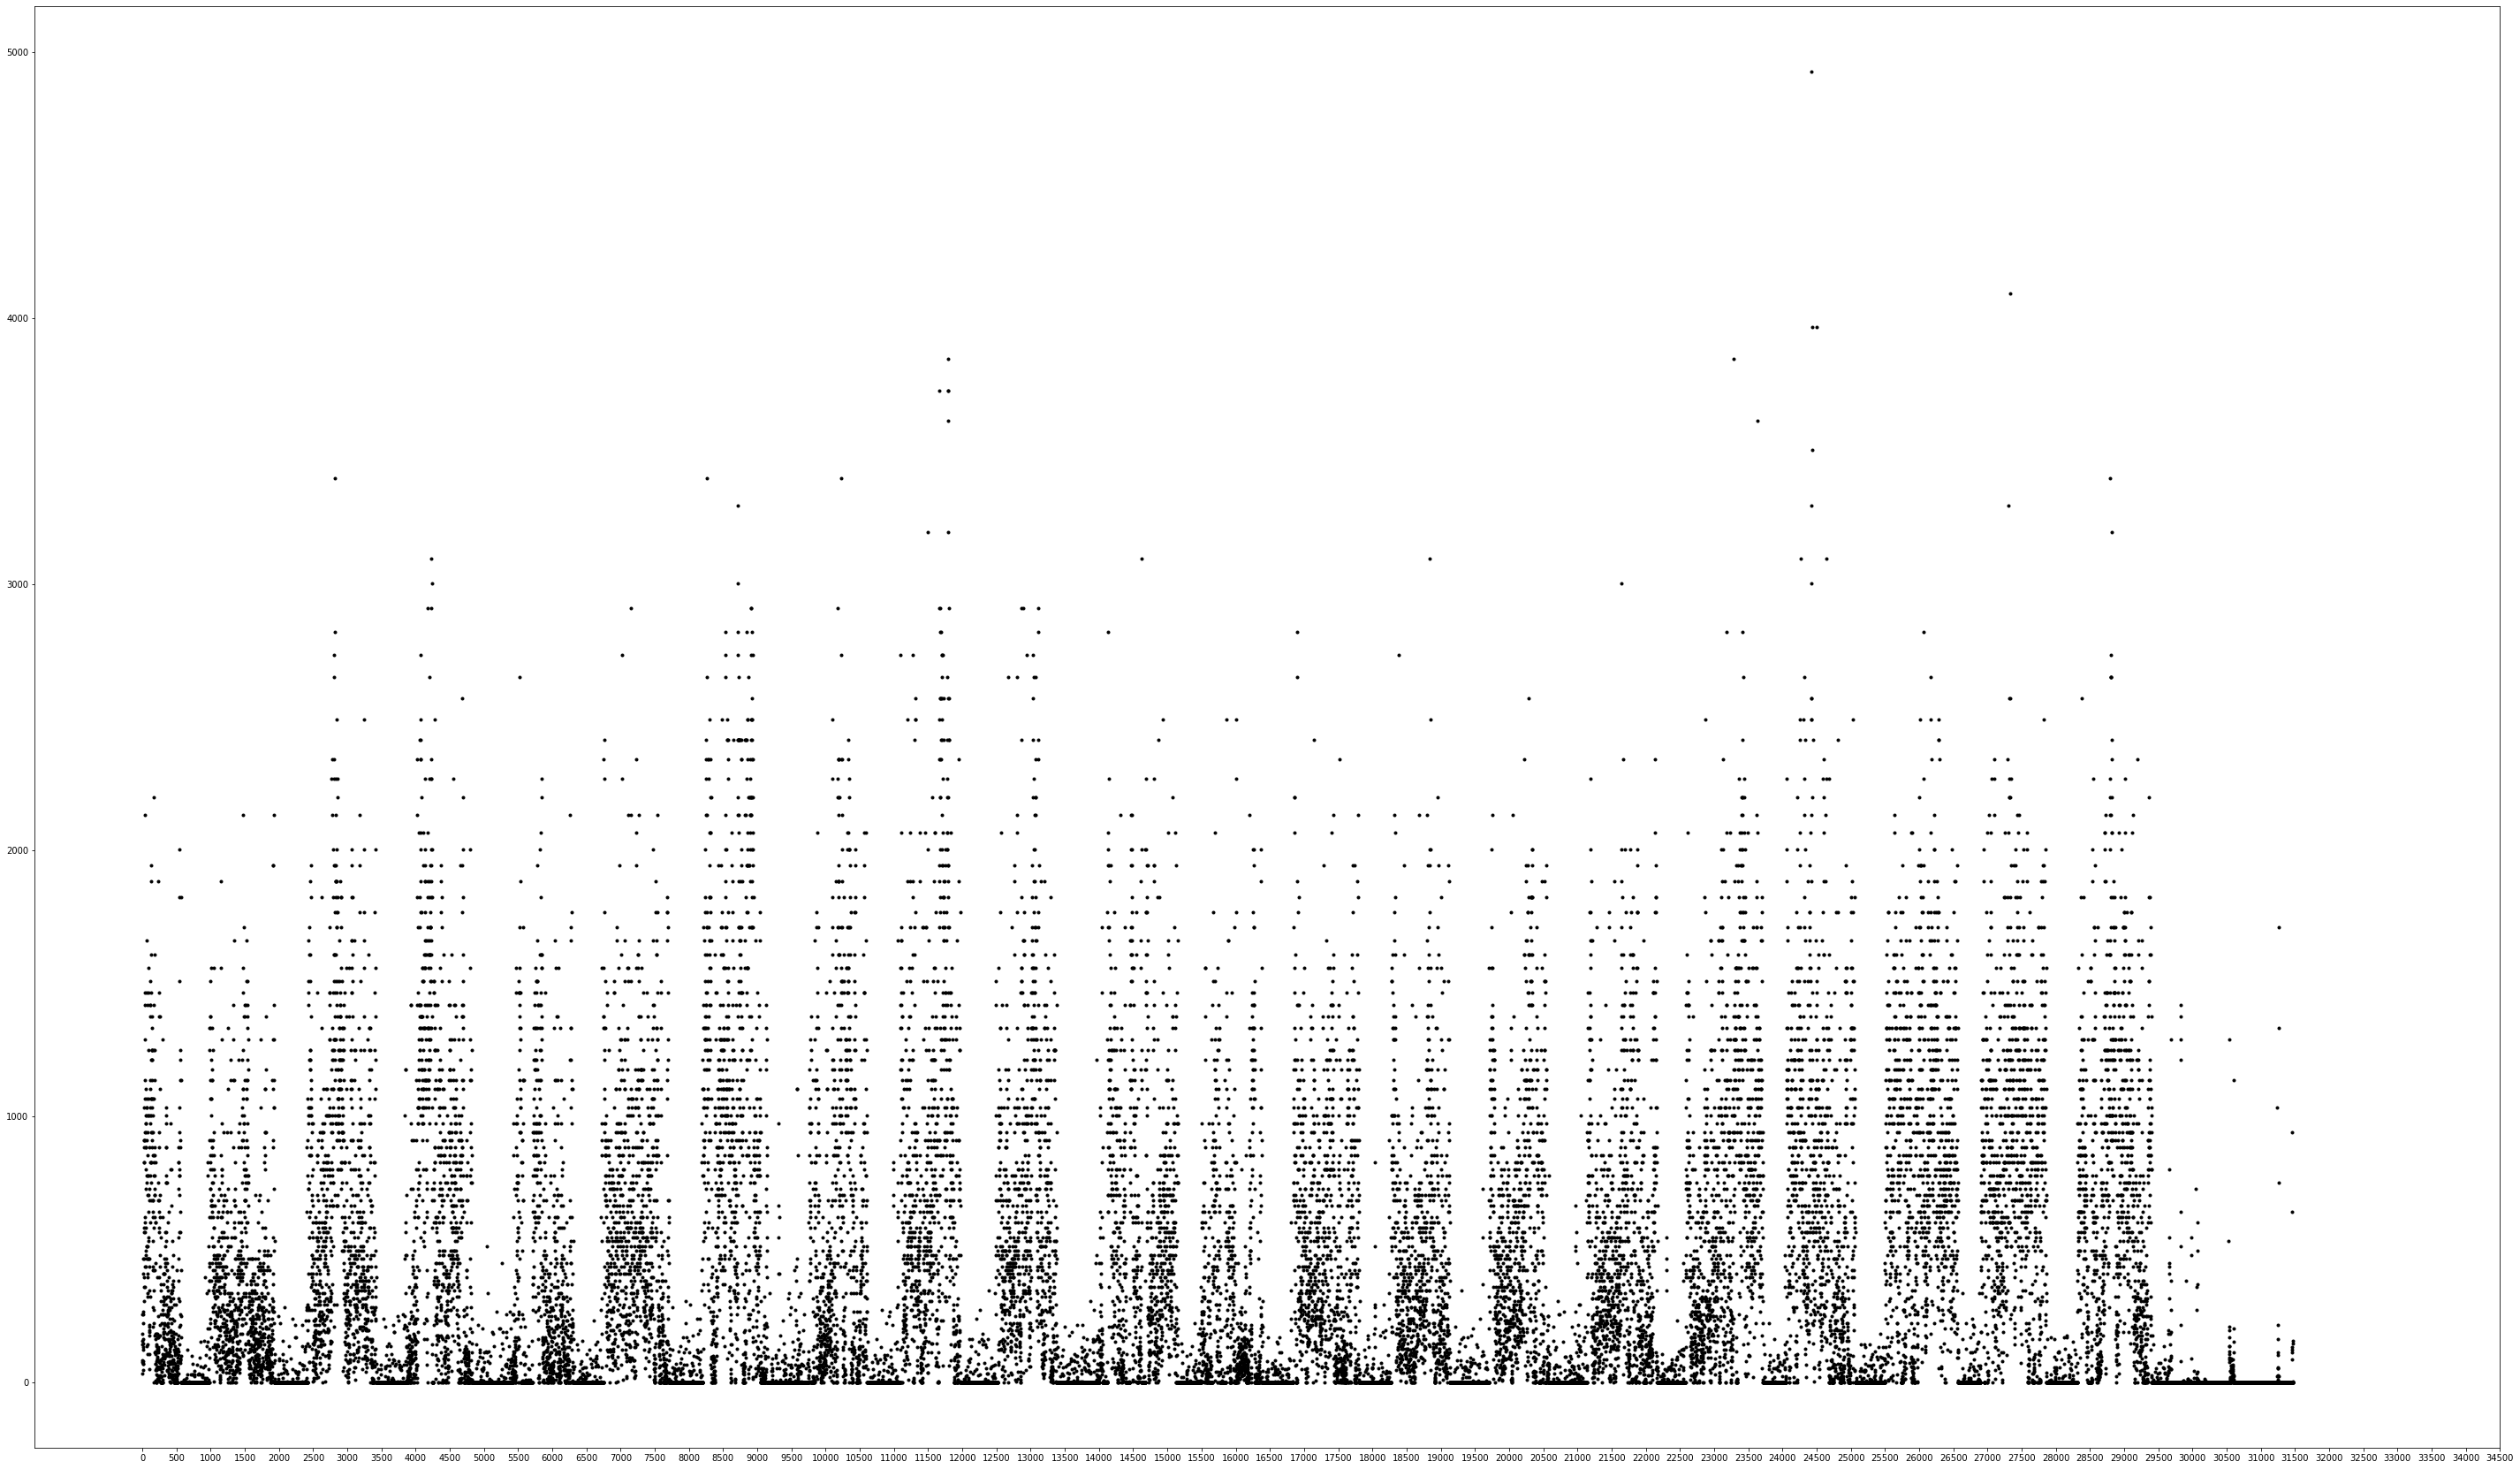

In [4]:
fig,ax = plt.subplots(figsize = (50,30))
controls[1]['activity'].plot(style = 'k.')
ax.set_xticks(range(0,35000,500))

In [5]:
controls[1].loc[controls[1]['activity']<=20].groupby('activity', axis = 0)['activity'].count()

activity
0     11324
3       164
5        80
7        50
8        87
10       69
12       54
13       80
15       63
17       65
18       49
20       58
Name: activity, dtype: int64

<BarContainer object of 55 artists>

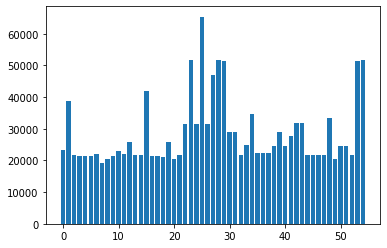

In [6]:
all_sizes = []
for x in conditions:
  all_sizes.append(len(x))

for x in controls:
  all_sizes.append(len(x))

plt.bar(range(len(all_sizes)), all_sizes)

**Outlierların Belirlenmesi**

Outlier işlemi burada işe yaramadığı (hiç outlier tespit edilmediği) için veride hiç bir değişiklik yapılmadı.

In [7]:
conditions_cp = conditions.copy()
k = 0.1

for n,x in enumerate(conditions_cp):
  Q1 = x.quantile(0.25)
  Q3 = x.quantile(0.75)
  Iqr = (Q3-Q1)
  print(len(conditions[n]))
  conditions_cp[n] = x[~((x < (Q1-Iqr*0.5)) | (x > (Q3+Iqr*0.5)))]
  print(len(conditions[n]))


23244
23244
38926
38926
21648
21648
21556
21556
21493
21493
21433
21433
22175
22175
19299
19299
20318
20318
21555
21555
22990
22990
22147
22147
25910
25910
21646
21646
21829
21829
41847
41847
21531
21531
21347
21347
21231
21231
25847
25847
20487
20487
21772
21772
31485
31485


**Verilerin 400'ün katına getirilmesi için fazlalıkların çıkarılması**

In [8]:
conditions_shapes = [x.shape[0] for x in conditions]
split_size = 400
reshaped_conditions = []
for n,x in enumerate(conditions_shapes):
  to_split_n = (conditions_shapes[n]%split_size)
  reshaped_conditions.append(conditions[n].iloc[:-to_split_n,:])

**Her verinin 400 timestamp'e eşitlenmesi**

In [9]:
resized_data = {}
for x,y in enumerate(reshaped_conditions):
  new_shape = int(y.shape[0]/split_size)
  dfs = []
  for z in range(1,split_size+1):
    mean = y[new_shape*(z-1):new_shape*z]['activity'].mean()
    dfs.append(mean)
  resized_data[x] = np.array(dfs)

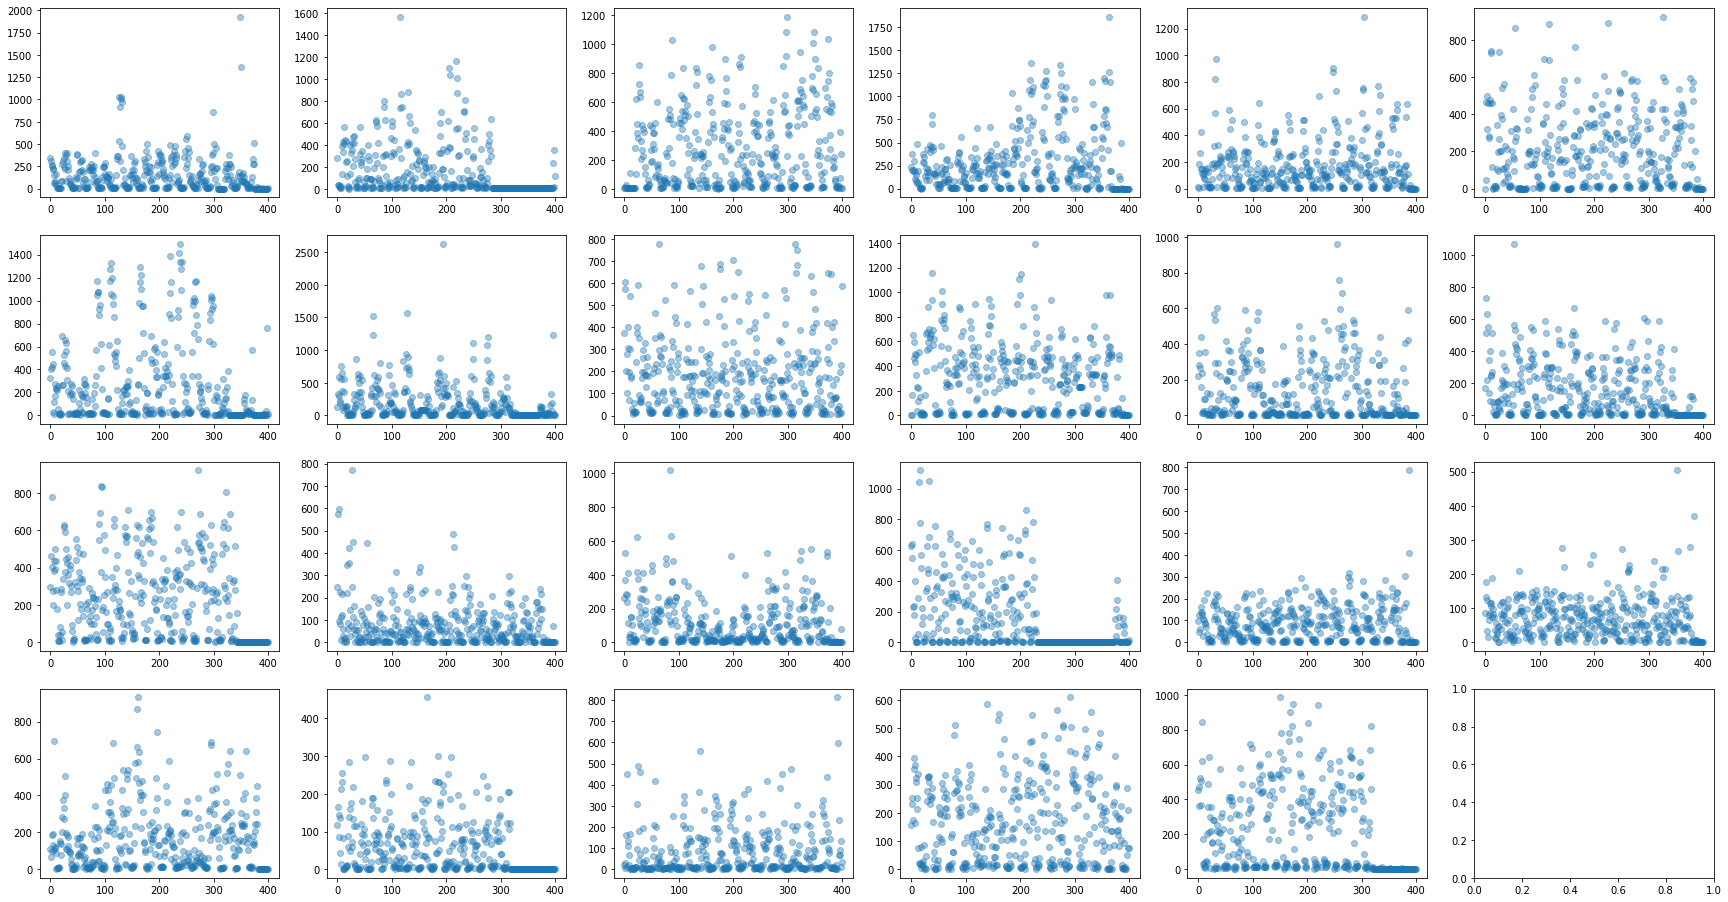

In [10]:
row_size = math.ceil(len(resized_data)/6)
col_size = math.ceil(len(resized_data)/4)

fig, ax = plt.subplots(row_size, col_size, figsize = (30,16))
ax = ax.ravel()

for x in range(len(conditions)):
  ax[x].scatter(range(split_size), resized_data[x], marker = 'o', alpha = 0.4)

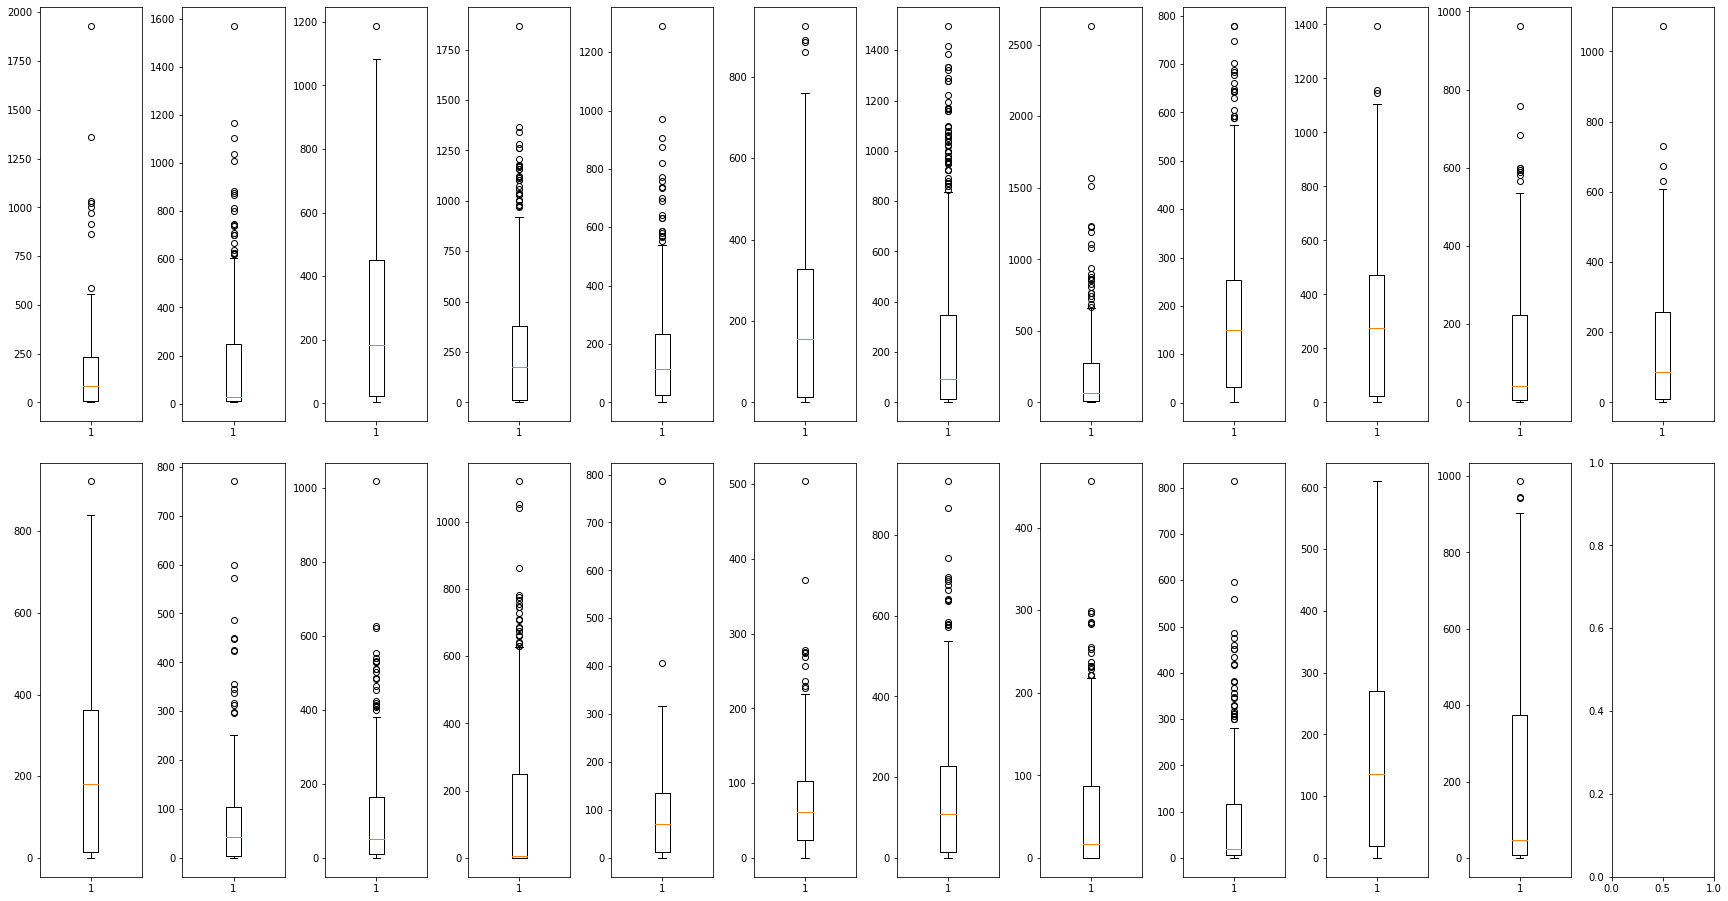

In [11]:
row_size = 2
col_size = math.ceil(len(resized_data)/2)

fig, ax = plt.subplots(row_size, col_size, figsize = (30,16))
fig.subplots_adjust(hspace = .1, wspace=.4)
ax = ax.ravel()

for x in range(len(resized_data)):
  ax[x].boxplot(resized_data[x])

In [12]:
scaler = StandardScaler()

scaled_data = []
for x in list(resized_data.values()):
  x = np.array(x).reshape(-1,1)
  scaled_data.append(scaler.fit_transform(x))

**Verilerin bölünmesi**

In [72]:
validation_size = 1
test_size = 2
train_size = len(resized_data)-validation_size-test_size

resized_data_ls = scaled_data

X_train = np.array(resized_data_ls[:][:train_size])
X_val = np.array(resized_data_ls[train_size+validation_size-1])
X_test = np.array(resized_data_ls[-test_size:])

y = np.array(scores['madrs2']-scores['madrs1'])

y_train = y[:train_size].reshape(train_size,-1)
y_val = y[train_size+validation_size-1].reshape( validation_size, -1)
y_test = y[train_size+validation_size:train_size+validation_size+test_size].reshape(-1,test_size)


In [73]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(1, 400, 1)
'''
X_test = X_test.reshape(1, split_size, test_size)
'''

'\nX_test = X_test.reshape(1, split_size, test_size)\n'

In [82]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.fit( X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.3048
Epoch 2/50
1/1 [==============================] - 0s 462ms/step - loss: 0.2957
Epoch 3/50
1/1 [==============================] - 0s 451ms/step - loss: 0.2859
Epoch 4/50
1/1 [==============================] - 0s 451ms/step - loss: 0.2763
Epoch 5/50
1/1 [==============================] - 0s 457ms/step - loss: 0.2686
Epoch 6/50
1/1 [==============================] - 0s 451ms/step - loss: 0.2618
Epoch 7/50
1/1 [==============================] - 0s 453ms/step - loss: 0.2574
Epoch 8/50
1/1 [==============================] - 0s 444ms/step - loss: 0.2560
Epoch 9/50
1/1 [==============================] - 0s 448ms/step - loss: 0.2570
Epoch 10/50
1/1 [==============================] - 0s 453ms/step - loss: 0.2594
Epoch 11/50
1/1 [==============================] - 0s 432ms/step - loss: 0.2594
Epoch 12/50
1/1 [==============================] - 0s 453ms/step - loss: 0.2591
Epoch 13/50
1/1 [==============================] - 0